In [ ]:
import os

# Possible values:
#   0 = all logs (default)
#   1 = filter out INFO logs
#   2 = filter out INFO and WARNING logs
#   3 = filter out all logs except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import re

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# create config to use both gpus on wickerman machine:
# 1. Nvidia A40 (25GB memory allocation)
# 2. Nvidia RTX 3060 (11GB memory allocation)

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_visible_devices(gpus[0], 'GPU') # use Use Nvidia A40 only

log_dev_conf_a40 = tf.config.LogicalDeviceConfiguration(
    memory_limit=25*1024 # 25 GB allocation for a40 GPU
)

tf.config.set_logical_device_configuration(
    gpus[0], # select GPU_0, i.e., Nvidia A40
    [log_dev_conf_a40] # apply 25GB config
)

# tf.config.set_visible_devices(gpus[1], 'GPU') # use RTX3060 only

# log_dev_conf_rtx3060 = tf.config.LogicalDeviceConfiguration(
#     memory_limit=12*1024 # 11 GB allocation for rtx3060 GPU
# )

# tf.config.set_logical_device_configuration(
#     gpus[1], # select GPU_1, i.e., Nvidia rtx3060
#     [log_dev_conf_rtx3060] # apply 11GB config
# )

# MultiGPU setup
# Create a MirroredStrategy.
# strategy = None
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

In [ ]:
import gc
import pandas as pd

In [ ]:
main_data = pd.read_csv('./data/card_transaction.v1.csv')
mcc = pd.read_csv("./data/mcc_codes.csv")

In [ ]:
# Merge the main_data with the mcc dataset on the 'MCC' column
data = pd.merge(main_data, mcc, left_on='MCC', right_on='mcc')
del main_data, mcc
gc.collect()

In [ ]:
from datetime import datetime

def convert_to_utc(data):
    
    year, month, day, time_str = data
    time_obj = datetime.strptime(time_str, "%H:%M").time()
    
    # Create full datetime object (assuming UTC)
    dt_obj = datetime(year, month, day, time_obj.hour, time_obj.minute)
    
    # Convert to UTC timestamp string
    return dt_obj.isoformat() + "Z"

In [ ]:
from pqdm.processes import pqdm as pqdm_processes
from pqdm.threads import pqdm as pqdm_threads
from tqdm import tqdm

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def categorical_labeling(values):
    label_encoder = LabelEncoder()
    
    # Fit and transform the values
    encoded_values = label_encoder.fit_transform(values)
    
    return np.array(encoded_values)

In [ ]:
data['UTC_Timestamp'] = [convert_to_utc(item) for item in tqdm(data[['Year', 'Month', 'Day', 'Time']].values)]

In [ ]:
data['UTC_Timestamp'] = pd.to_datetime(data['UTC_Timestamp'])
data = data.sort_values(by=['User', 'Card', 'UTC_Timestamp'])


In [ ]:
data['Amount'] = data['Amount'].map(lambda x: float(x[1:]))

data['has_error'] = (data['Errors?'].isna() == False).astype(int)

data['Minutes_Since_Midnight'] = data['Time'].apply(lambda t: int(t.split(':')[0]) * 60 + int(t.split(':')[1]))

data.fillna({'irs_reportable': 'NA'}, inplace=True)
data.fillna({'irs_description': 'NA'}, inplace=True)
data['irs_reportable_labeled'] = categorical_labeling(data['irs_reportable'])
data['irs_description_labeled'] = categorical_labeling(data['irs_description'])

data['Is_Fraud_Binary'] = data['Is Fraud?'].map({'Yes': 1, 'No': 0})
data['Use_chip_labeled'] = data['Use Chip'].map({'Swipe Transaction': 0, 'Online Transaction': 1, 'Chip Transaction': 2})
data['city_labeled'] = categorical_labeling(data['Merchant City'])

gc.collect()

In [ ]:
seq_features = ['Month', 'Day', 'MCC', 'Minutes_Since_Midnight', 'city_labeled', 'Use_chip_labeled', 'Amount', 'has_error', 'irs_reportable_labeled', 'irs_description_labeled']
filtered_data = data[seq_features]

In [ ]:
import pickle as pkl


In [ ]:

pkl.dump(filtered_data, open('./data/engineered_data.pkl', 'wb'))
pkl.dump(data, open('./data/engineered_data_raw.pkl', 'wb'))

In [29]:
filtered_data = pkl.load(open('./data/engineered_data.pkl', 'rb'))
data = pkl.load(open('./data/engineered_data_raw.pkl', 'rb'))

In [30]:
seq_features = ['Month', 'Day', 'MCC', 'Minutes_Since_Midnight', 'city_labeled', 'Use_chip_labeled', 'Amount', 'has_error', 'irs_reportable_labeled', 'irs_description_labeled']
# filtered_data = data[seq_features]

In [31]:
data = data[data['User'].astype(int).isin(list(range(100)))]
filtered_data = data[seq_features]

In [32]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert 'Is Fraud?' column to binary (Yes=1, No=0)
# data['Is_Fraud_Binary'] = data['Is Fraud?'].map({'Yes': 1, 'No': 0})
# data['Use_chip_labeled'] = data['Use Chip'].map({'Swipe Transaction': 0, 'Online Transaction': 1, 'Chip Transaction': 2})
# data['city_labeled'] = categorical_labeling(data['Merchant City'])
# # Select numerical columns for correlation analysis
# numerical_cols = ['Day', 'MCC', 'Minutes_Since_Midnight', 'city_labeled', 'Amount', 'Use_chip_labeled', 'Is_Fraud_Binary']

# # Compute correlation matrix
# correlation_matrix = data[numerical_cols].corr()

# # Visualize correlation using a heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Feature Correlation with Fraud")
# plt.show()

# # Display sorted correlation values with 'Is Fraud?'
# correlation_with_fraud = correlation_matrix['Is_Fraud_Binary'].drop('Is_Fraud_Binary').sort_values(ascending=False)
# correlation_with_fraud


In [33]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix
# from imblearn.over_sampling import SMOTE

# # Assuming `subset_df` is your dataframe with all required columns.
# # The target column should be binary (e.g., 'Is_Fraud_Binary'), and the features are:
# features = ['Month', 'Day', 'MCC', 'Minutes_Since_Midnight', 'city_labeled', 'Use_chip_labeled', 'Amount', 'has_error', 'irs_reportable_labeled', 'irs_description_labeled']
# target = 'Is_Fraud_Binary'

# # Extract features and target from the dataframe
# X = data[features]
# y = data[target]

# # Perform a train/test split with stratification to preserve class distribution
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, stratify=y, random_state=42
# )

# # Address class imbalance using SMOTE on the training set
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # Define individual strong predictors
# clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
# clf_lr = LogisticRegression(max_iter=1000, random_state=42)

# # Build a soft-voting ensemble classifier
# ensemble = VotingClassifier(
#     estimators=[('rf', clf_rf), ('gb', clf_gb), ('lr', clf_lr)],
#     voting='soft'
# )

# # Train the ensemble model on the resampled (balanced) training data
# ensemble.fit(X_train_res, y_train_res)

# # Make predictions on the test set
# y_pred = ensemble.predict(X_test)

# # Evaluate the model's performance
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

In [62]:
WINDOW_SIZE=20
seq_features = ['Month', 'Day', 'MCC', 'Minutes_Since_Midnight', 'city_labeled', 'Use_chip_labeled', 'Amount', 'has_error', 'irs_reportable_labeled', 'irs_description_labeled']

In [73]:
import numpy as np
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm

NUM_PROCESSES = 12  

def process_user_card_group(args):
    """
    Process a single user-card group in parallel.
    Extracts sequences and aggregated features, including additional behavioral and frequency-based features.
    """
    user_card, group, window_size, feature_cols, target_col = args
    group = group.sort_values(by='UTC_Timestamp')
    arr = group[feature_cols].values
    
    X_seq_local, X_agg_local, y_local = [], [], []
    
    # Get feature indices for amount and categorical features
    if 'Amount' in feature_cols:
        amount_idx = feature_cols.index('Amount')
    else:
        amount_idx = None
    
    if 'MCC' in feature_cols:
        mcc_idx = feature_cols.index('MCC')
    else:
        mcc_idx = None
    
    if 'Merchant_ID' in feature_cols:
        merchant_idx = feature_cols.index('Merchant_ID')
    else:
        merchant_idx = None

    for i in range(window_size, len(group)):
        seq_window = arr[i - window_size:i]  # (window_size, num_features)
        X_seq_local.append(seq_window)

        # Compute basic aggregated statistics
        agg_mean = seq_window.mean(axis=0)
        agg_std = seq_window.std(axis=0)
        agg_min = seq_window.min(axis=0)
        agg_max = seq_window.max(axis=0)
        agg_range = agg_max - agg_min

        # Transaction Frequency Features
        timestamps = group.iloc[i - window_size:i]['UTC_Timestamp']
        time_diffs = timestamps.diff().dt.total_seconds().dropna().values  # Time differences in seconds

        avg_time_diff = np.mean(time_diffs) if len(time_diffs) > 0 else 0
        max_time_diff = np.max(time_diffs) if len(time_diffs) > 0 else 0
        min_time_diff = np.min(time_diffs) if len(time_diffs) > 0 else 0

        # Large Transactions Features
        if amount_idx is not None:
            amounts = seq_window[:, amount_idx]
            high_value_txns = np.sum(amounts > np.percentile(amounts, 75)) / window_size  # % of high-value transactions
            rolling_sum = np.sum(amounts)
            rolling_avg = np.mean(amounts)
        else:
            high_value_txns, rolling_sum, rolling_avg = 0, 0, 0

        # Merchant & MCC Diversity Features
        if merchant_idx is not None:
            unique_merchants = len(set(seq_window[:, merchant_idx]))
        else:
            unique_merchants = 0

        if mcc_idx is not None:
            unique_mcc_codes = len(set(seq_window[:, mcc_idx]))
        else:
            unique_mcc_codes = 0

        # Combine all features
        agg_features = np.concatenate([
            agg_mean, agg_std, agg_min, agg_max, agg_range,
            [avg_time_diff, max_time_diff, min_time_diff],  # Transaction frequency
            [high_value_txns, rolling_sum, rolling_avg],    # Large transaction features
            [unique_merchants, unique_mcc_codes]           # Merchant & MCC diversity
        ])

        X_agg_local.append(agg_features)
        y_local.append(group.iloc[i][target_col])

    return X_seq_local, X_agg_local, y_local

def create_sequences_parallel(df, window_size=10, feature_cols=[], target_col='Is_Fraud_Binary'):
    """
    Process the user-card groups in parallel to speed up sequence generation.
    """
    grouped_data = [(key, group, window_size, feature_cols, target_col) for key, group in df.groupby(['User', 'Card'])]
    
    # Use multiprocessing Pool to process groups in parallel
    with Pool(NUM_PROCESSES) as pool:
        results = list(tqdm(pool.imap(process_user_card_group, grouped_data), total=len(grouped_data)))
    
    # Combine results from all processes
    X_seq, X_agg, y = [], [], []
    for X_s, X_a, y_l in results:
        X_seq.extend(X_s)
        X_agg.extend(X_a)
        y.extend(y_l)
    
    return np.array(X_seq), np.array(X_agg), np.array(y)

# Example usage:
X_seq, X_agg, y = create_sequences_parallel(data, window_size=20, feature_cols=seq_features)

print("X_seq shape:", X_seq.shape)   # (num_samples, WINDOW_SIZE, num_features)
print("X_agg shape:", X_agg.shape)     # New feature set including behavior-based features
print("y shape:", y.shape)


100%|██████████| 285/285 [01:42<00:00,  2.78it/s]


X_seq shape: (1252585, 20, 10)
X_agg shape: (1252585, 58)
y shape: (1252585,)


In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
# Split data into training and testing sets (stratify to preserve fraud ratios)
X_seq_train, X_seq_test, X_agg_train, X_agg_test, y_train, y_test = train_test_split(
    X_seq, X_agg, y, test_size=0.3, stratify=y, random_state=42
)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_agg, y, test_size=0.3, stratify=y, random_state=42)

In [77]:
X_train_nonfraud = X_train[y_train == 0]

iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
iso_forest.fit(X_train_nonfraud)

# Compute anomaly scores for both training and testing data.
# The decision_function returns higher values for "normal" points.
train_scores = iso_forest.decision_function(X_train).reshape(-1, 1)
test_scores = iso_forest.decision_function(X_test).reshape(-1, 1)

In [78]:
# ---------------------------
# 3. Stage 2: Append Anomaly Scores and Train a Cost-Sensitive Classifier
# ---------------------------
# Append the anomaly scores as a new feature
X_train_aug = np.concatenate([X_train, train_scores], axis=1)
X_test_aug = np.concatenate([X_test, test_scores], axis=1)

# Compute the scale_pos_weight to counter class imbalance
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

# Train an XGBoost classifier with cost sensitivity
xgb_model = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight,
                          random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_aug, y_train)

# ---------------------------
# 4. Evaluate the Ensemble Model
# ---------------------------
y_pred = xgb_model.predict(X_test_aug)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/home/vedant/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:10:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    375383
           1       0.17      0.66      0.27       393

    accuracy                           1.00    375776
   macro avg       0.59      0.83      0.64    375776
weighted avg       1.00      1.00      1.00    375776

Confusion Matrix:
[[374122   1261]
 [   132    261]]


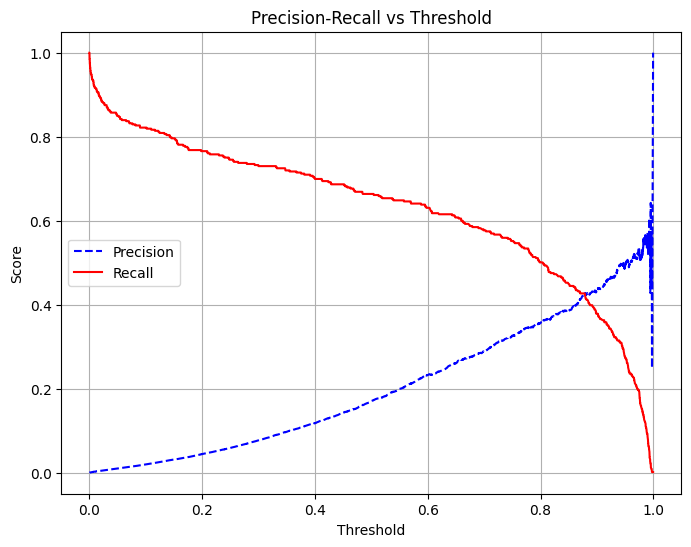

Optimal Decision Threshold: 0.878
Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    375383
           1       0.12      0.70      0.20       393

    accuracy                           0.99    375776
   macro avg       0.56      0.85      0.60    375776
weighted avg       1.00      0.99      1.00    375776

Confusion Matrix with Adjusted Threshold:
[[373342   2041]
 [   118    275]]


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Step 1: Get predicted fraud probabilities from the trained model
y_probs = xgb_model.predict_proba(X_test_aug)[:, 1]  # Get fraud probabilities

# Step 2: Compute Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Step 3: Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Step 4: Choose Best Threshold
# We want a balance between Precision and Recall (e.g., F1-score maximization)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Decision Threshold: {best_threshold:.3f}")

# Step 5: Use the new threshold for final fraud classification
y_pred_adjusted = (y_probs >= 0.4).astype(int)

# Step 6: Evaluate Model with New Threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))


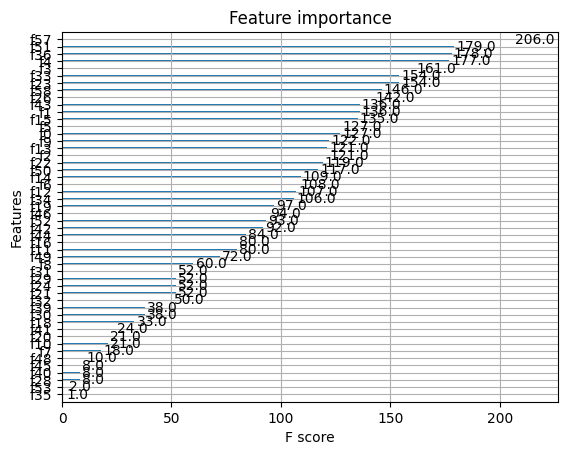

In [81]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

In [82]:
import pandas as pd
import numpy as np

# Get feature importance values
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
feature_importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print("Top Important Features:")
print(feature_importance_df.head(20))

# Display least important features
print("\nLeast Important Features:")
print(feature_importance_df.tail(20))


Top Important Features:
   Feature  Importance
48     f57       206.0
45     f51       179.0
33     f36       178.0
4       f4       177.0
3       f3       161.0
30     f33       154.0
22     f23       154.0
49     f58       146.0
24     f26       142.0
38     f43       136.0
1       f1       136.0
15     f15       135.0
0       f0       127.0
5       f5       127.0
9       f9       122.0
13     f13       121.0
2       f2       121.0
21     f22       119.0
44     f50       117.0
14     f14       109.0

Least Important Features:
   Feature  Importance
43     f49        72.0
8       f8        60.0
23     f24        52.0
28     f31        52.0
26     f29        52.0
20     f21        52.0
29     f32        50.0
34     f39        38.0
27     f30        38.0
17     f18        33.0
36     f41        24.0
19     f20        21.0
10     f10        21.0
7       f7        18.0
42     f48        10.0
40     f45         8.0
35     f40         8.0
25     f28         8.0
47     f53         2.0
32    

In [83]:
# Set threshold for feature selection
importance_threshold = 50  # Adjust this based on results

# Get low-importance features
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature'].tolist()

print(f"\nRemoving {len(low_importance_features)} low-importance features:\n{low_importance_features}")



Removing 13 low-importance features:
['f39', 'f30', 'f18', 'f41', 'f20', 'f10', 'f7', 'f48', 'f45', 'f40', 'f28', 'f53', 'f35']


In [85]:
X_train

array([[1.10000e+01, 2.08500e+01, 5.97085e+03, ..., 2.82620e+01,
        0.00000e+00, 1.30000e+01],
       [4.00000e+00, 2.04000e+01, 5.70390e+03, ..., 2.52550e+01,
        0.00000e+00, 1.10000e+01],
       [4.00000e+00, 1.19000e+01, 5.27230e+03, ..., 5.68630e+01,
        0.00000e+00, 8.00000e+00],
       ...,
       [1.10000e+01, 1.57500e+01, 5.94205e+03, ..., 2.01240e+01,
        0.00000e+00, 8.00000e+00],
       [8.00000e+00, 1.42500e+01, 5.37670e+03, ..., 4.73895e+01,
        0.00000e+00, 8.00000e+00],
       [1.00500e+01, 2.69000e+01, 5.46100e+03, ..., 2.37035e+01,
        0.00000e+00, 8.00000e+00]])

In [87]:

# Step 2: Identify Features to Remove
importance_threshold = 50  # Set threshold (Adjust if needed)

# Get feature indices that are below the threshold
low_importance_indices = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature_Index'].tolist()

# Step 3: Remove Low-Importance Features from NumPy Arrays
X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)

# Retrain the model on the reduced feature set
xgb_model_reduced = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight,
                                  random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_reduced.fit(X_train_reduced, y_train)

# Evaluate the new model
y_probs_reduced = xgb_model_reduced.predict_proba(X_test_reduced)[:, 1]
y_pred_adjusted_reduced = (y_probs_reduced >= 0.4).astype(int)

print("\nClassification Report after Feature Selection:")
print(classification_report(y_test, y_pred_adjusted_reduced))

print("\nConfusion Matrix after Feature Selection:")
print(confusion_matrix(y_test, y_pred_adjusted_reduced))


KeyError: 'Feature_Index'